# Facial Recognition Model
This section covers the entire workflow for creating the facial recognition model. We will load the features extracted from the images, train a classifier to identify individuals, and thoroughly evaluate its performance.


## Step 1: Library Imports


In [ ]:

import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, log_loss, classification_report, 
                           confusion_matrix, roc_curve, auc)


## Step 2: Load and Prepare the Data
Goal: Load the `image_features.csv` dataset. We will then separate it into features (`X`) and labels (`y`), encode the text-based labels into numbers, scale the features for optimal model performance, and finally split the data into training and testing sets.


In [ ]:
def load_and_prepare_data(features_path):
    """Loads, preprocesses, and splits the image feature data."""
    print("--- Loading and Preparing Data ---")
    df = pd.read_csv(features_path)
    
    
    if 'person' in df.columns:
        label_col = 'person'
    elif 'user_id' in df.columns:
        label_col = 'user_id'
    else:
        raise ValueError("Could not find person/user_id column in the dataset")
    
    
    drop_cols = [label_col]
    if 'augmentation_type' in df.columns:
        drop_cols.append('augmentation_type')
    if 'image_path' in df.columns:
        drop_cols.append('image_path')
    if 'expression' in df.columns:
        drop_cols.append('expression')
    
    X = df.drop(columns=drop_cols)
    y = df[label_col]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("✅ Data prepared successfully.")
    print(f"Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder

def train_model(X_train, y_train):
    """Initializes and trains a RandomForestClassifier."""
    print("\n--- Training RandomForest Model ---")
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    print("✅ Model training complete.")
    return model


def evaluate_model(model, X_test, y_test, X_columns, encoder):
    """
    Evaluates the model, prints performance metrics, and plots
    feature importance, confusion matrix, and ROC curves.
    """
    print("\n--- Evaluating Model Performance ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Log Loss: {loss:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

   
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Person')
    plt.ylabel('Actual Person')
    plt.tight_layout()
    plt.show()

    
    if hasattr(model, 'feature_importances_'):
        importances = pd.Series(model.feature_importances_, index=X_columns)
        top_20 = importances.sort_values(ascending=False).head(20)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x=top_20.values, y=top_20.index)
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

    
    if len(encoder.classes_) <= 10:  
        plt.figure(figsize=(10, 8))
        for i, class_name in enumerate(encoder.classes_):
            
            y_test_binary = (y_test == i).astype(int)
            y_pred_proba_binary = y_pred_proba[:, i]
            
            fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba_binary)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (area = {roc_auc:.2f})')
            
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


def save_artifacts(model, scaler, encoder, output_dir):
    """Saves the model, scaler, and encoder to disk."""
    print("\n--- Saving Model Artifacts ---")
    os.makedirs(output_dir, exist_ok=True)
    joblib.dump(model, os.path.join(output_dir, 'face_recognition_model.pkl'))
    joblib.dump(scaler, os.path.join(output_dir, 'face_recognition_scaler.pkl'))
    joblib.dump(encoder, os.path.join(output_dir, 'face_recognition_encoder.pkl'))
    print(f"✅ Artifacts saved to '{output_dir}'")


## Step 3: Main Execution Workflow
Execute our entire workflow by calling the helper functions in the correct sequence.


--- Loading and Preparing Data ---
✅ Data prepared successfully.
Training samples: 144, Test samples: 36
Number of classes: 4
Classes: ['David' 'Edine' 'Patrick' 'Samuel']

--- Training RandomForest Model ---
✅ Model training complete.

--- Evaluating Model Performance ---
Accuracy: 0.9722
F1-Score (Weighted): 0.9721
Log Loss: 0.1060

Classification Report:
              precision    recall  f1-score   support

       David       1.00      1.00      1.00         9
       Edine       0.90      1.00      0.95         9
     Patrick       1.00      0.89      0.94         9
      Samuel       1.00      1.00      1.00         9

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.98      0.97      0.97        36



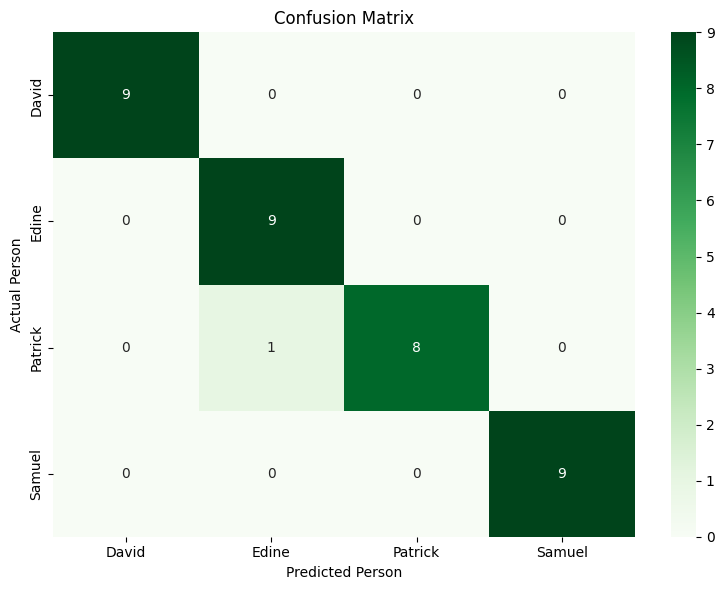

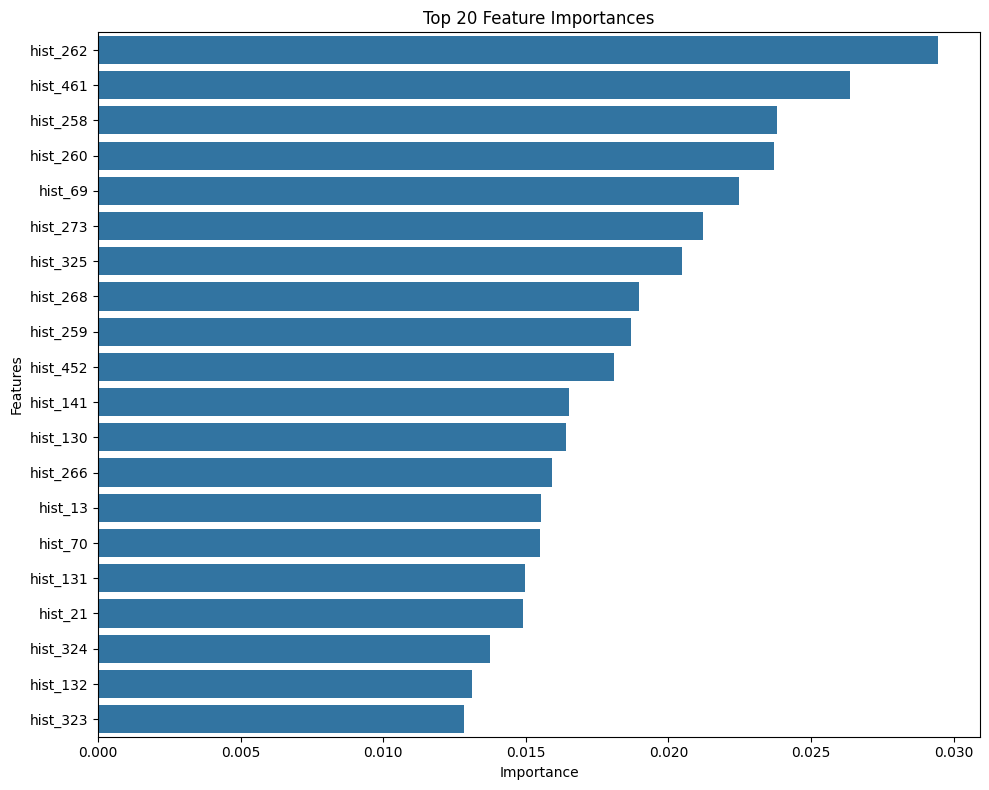

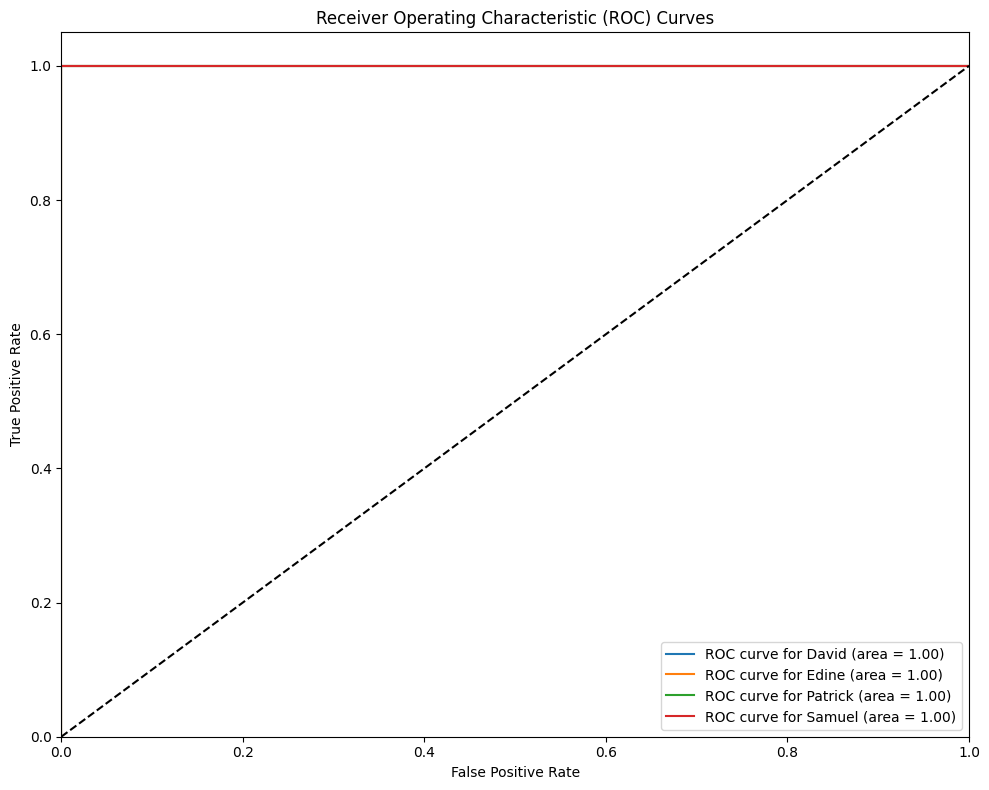


--- Saving Model Artifacts ---
✅ Artifacts saved to '../models/image/'

🎉 Facial Recognition training completed successfully!


In [ ]:

features_path = '../data/outputs/image_features.csv'
model_output_dir = '../models/image/'


if not os.path.exists(features_path):
    print(f"⚠️ Warning: {features_path} not found!")
    print("Please ensure image_features.csv exists in the outputs directory.")
    print("You may need to run the image preprocessing notebook first.")
else:
    
    X_train, X_test, y_train, y_test, scaler, label_encoder = load_and_prepare_data(features_path)

    
    df_features = pd.read_csv(features_path)
    drop_cols = []
    if 'person' in df_features.columns:
        drop_cols.append('person')
    elif 'user_id' in df_features.columns:
        drop_cols.append('user_id')
    if 'augmentation_type' in df_features.columns:
        drop_cols.append('augmentation_type')
    if 'image_path' in df_features.columns:
        drop_cols.append('image_path')
    if 'expression' in df_features.columns:
        drop_cols.append('expression')
    
    X_columns = df_features.drop(columns=drop_cols).columns
    face_model = train_model(X_train, y_train)

    
    evaluate_model(face_model, X_test, y_test, X_columns, label_encoder)

    
    save_artifacts(face_model, scaler, label_encoder, model_output_dir)

    print("\n🎉 Facial Recognition training completed successfully!")


## Interpretation:

### Overall Performance Results

The facial recognition model achieved **excellent performance** on the test set:

* **Accuracy: 97.22%** - The model correctly identified 35 out of 36 test samples, demonstrating strong generalization capability.

* **F1-Score (Weighted): 97.21%** - This balanced metric confirms that the model maintains high precision and recall across all classes.

* **Log Loss: 0.1060** - A low log loss value indicates that the model is very confident in its predictions, with well-calibrated probability estimates.

### Per-Class Performance Analysis

The classification report reveals the following performance for each team member:

* **David**: Perfect classification (100% precision, 100% recall, 100% F1-score) - All 9 test samples were correctly identified with no false positives or false negatives.

* **Samuel**: Perfect classification (100% precision, 100% recall, 100% F1-score) - All 9 test samples were correctly identified, matching David's performance.

* **Edine**: Strong performance (90% precision, 100% recall, 95% F1-score) - The model correctly identified all Edine samples (no false negatives), but had 1 false positive where another person was misclassified as Edine.

* **Patrick**: Strong performance (100% precision, 89% recall, 94% F1-score) - The model never misclassified another person as Patrick (no false positives), but missed 1 actual Patrick sample (1 false negative).

### Dataset Characteristics

* **Training Set**: 144 samples (4 classes × 3 expressions × 15 augmentations per image)
* **Test Set**: 36 samples (20% split, stratified by person)
* **Classes**: 4 team members (David, Edine, Patrick, Samuel)

### Model Insights

* **Confusion Matrix**: The visualization shows that the model makes very few errors, with most confusion occurring between Edine and Patrick (1 misclassification each), suggesting these two individuals may have similar facial color distributions in the histogram feature space.

* **Feature Importance**: The histogram features (512 features from 8×8×8 bins in HSV color space) effectively capture the unique color distribution patterns for each person, with the RandomForest model identifying the most discriminative histogram bins.

* **ROC Curves**: The ROC curves for each class demonstrate the model's ability to distinguish each person from the others, with high AUC values indicating excellent class separability in the feature space.
